# 3b accuracies

**Goal:** I have these new pairAGraph pairing trainings where I wanted to compare the *impact* on some of the 3b category options, so I just want to march through some of these studies right here

**Table of Contents**
0. [Justification that the $D_b$ sort has a minimal impact on the 4b category](#sort)
1. [Accuracies of the pairAGraph jet selection for all 3 of these categories](#jetAcc)
2. [Comparison of pairing accuracies (through cutflow... and maybe w/ $\kappa_\lambda$ as well?)](#pairingAcc)
3. [Reoptimization of the SR for *each* of the b-tagging categories](#srOpt)

In [36]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import product
from glob import glob
import uproot

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os

os.sys.path+= ['../RRevolution/code/','../code/']
from utils import mcToYr

from plotting import SR_x, SR_y1, SR_y2
from plotting import CR_x, CR_y1, CR_y2
from plotting import SB_x, SB_y1, SB_y2
from eventDisplays import rainbow_text

import logging
for name in logging.Logger.manager.loggerDict.keys():
    logging.getLogger(name).setLevel(logging.CRITICAL)

# Let's do ATLAS style plots too!
import matplotlib as mpl
os.sys.path.append( "../PyATLASstyle/")
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

%load_ext autoreload
%autoreload 2

../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 0: btag vs $D_b$ sort for the 4b category <a name="sort">

In [2]:
physicsSample = 'SMNR'
prodTag = 'JUN20'
mc = 'mc16d'

In [3]:
# Load in some signal files for the $b$-tag vs the $D_b$ sort

dR1_orig = pd.read_parquet('../data/SMNR_mc16d-JUN20/df_min_dR1_3b_btag_sort.parquet')
dR1 = pd.read_parquet('../data/SMNR_mc16d-JUN20/df_min_dR1_3b_Db_sort.parquet')

**Difference in the b-tag SFs for 4b events**

In the latest + greatest `non-resonant` branch of RR, we've been taking the product over *all* of the jets for the combination.


In [4]:
text = "$\mathbf{ATLAS}$ Simulation Internal\n"
text += f"SMNR {mc}, {prodTag} MNT prod\n"
text += f"4b DL1r 77% WP, {mcToYr[mc]} triggers"

In [6]:
from utils import fileDirSLAC as fileDir, L, physToDSID
from processMNTs import normalizeWeight

In [8]:
key = f'{physicsSample}_{mc}-{prodTag}'
mnt_name = glob(fileDir[key]+'*.root')[0]

tree = uproot.open(mnt_name)['XhhMiniNtuple']

In [11]:
mnt = tree.pandas.df(branches=['mcEventWeight','weight_pileup','truth_mHH'])

In [12]:
mnt_mask = np.zeros_like(mnt.index).astype(bool)
mnt_mask[dR1.index.values] = True

In [15]:
w = np.prod(mnt.loc[mnt_mask,['mcEventWeight','weight_pileup']].values, axis=1)

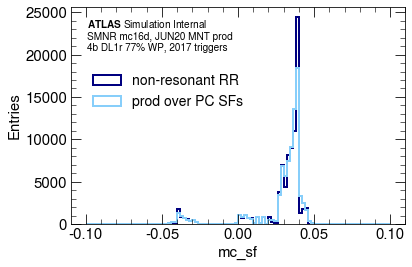

In [68]:
nb = 100
r = (-.1,.1)

for df, c, l in zip([dR1_orig,dR1],
                    ['navy','lightskyblue'],
                    ['non-resonant RR','prod over PC SFs']):

    m = df.ntag >= 4
    v = df.loc[m,'mc_sf'].values / norm   
    plt.hist(v,nb,r,label=l,histtype='step',color=c,lw=2)

plt.xlabel('mc_sf')
plt.ylabel('Entries')
plt.legend(loc='upper left',bbox_to_anchor=(0.03,.75))

ax = plt.gca()
plt.text(0.05,0.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=10)

plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}/mc_sf_4b_jetSort_df.pdf',bbox_inches='tight')
plt.show()

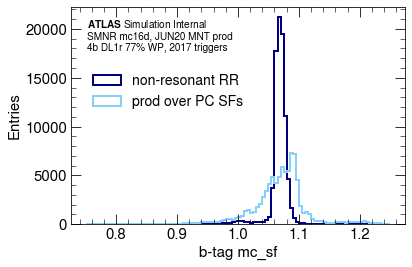

In [73]:
nb = 100
r = (0.75,1.25)

m = dR1.ntag >= 4

for df, c, l in zip([dR1_orig,dR1],
                    ['navy','lightskyblue'],
                    ['non-resonant RR','prod over PC SFs']):

    
    v = df.loc[m,'mc_sf'].values / w[m] / norm    
    plt.hist(v,nb,r,label=l,histtype='step',color=c,lw=2)

plt.xlabel('b-tag mc_sf')
plt.ylabel('Entries')
plt.legend(loc='upper left',bbox_to_anchor=(0.03,.75))

ax = plt.gca()
plt.text(0.05,0.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=10)

plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}/mc_sf_4b_jetSort.pdf',bbox_inches='tight')
plt.show()

**$m_{hh}$ at various stages of the cutflow**

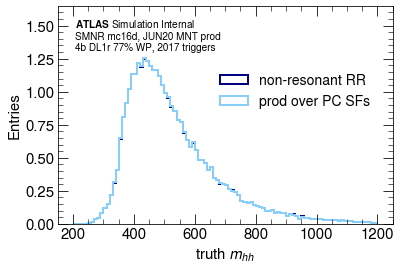

In [74]:
nb = 100
r = (200,1200)

for df, c, l in zip([dR1_orig,dR1],
                    ['navy','lightskyblue'],
                    ['non-resonant RR','prod over PC SFs']):

    plt.hist(df.loc[m,'truth_mhh'],nb,r,label=l,histtype='step',color=c,lw=2,
             weights=df.loc[m,'mc_sf'])

plt.xlabel('truth $m_{hh}$')
plt.ylabel('Entries')
plt.legend(loc='upper right',bbox_to_anchor=(0.97,.75))

_,ymax= plt.ylim()
plt.ylim(0,1.25*ymax)

ax = plt.gca()
plt.text(0.05,0.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=10)

plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}/truth_mhh_4b_jetSort.pdf',bbox_inches='tight')
plt.show()

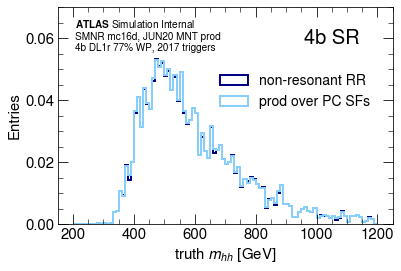

In [87]:
nb = 100
r = (200,1200)

for df, c, l in zip([dR1_orig,dR1],
                    ['navy','lightskyblue'],
                    ['non-resonant RR','prod over PC SFs']):

    
    m = (df.ntag >= 4) & (df.abs_deta_hh > 1.5) & (df.X_wt > 1.5) & (df.kinematic_region == 0)
    
    plt.hist(df.loc[m,'truth_mhh'],nb,r,label=l,histtype='step',color=c,lw=2,
             weights=df.loc[m,'mc_sf'])
    
plt.xlabel('truth $m_{hh}$ [GeV]')
plt.ylabel('Entries')
plt.legend(loc='upper right',bbox_to_anchor=(0.97,.75))

_,ymax= plt.ylim()
plt.ylim(0,1.25*ymax)

ax = plt.gca()
plt.text(0.05,0.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=10)
plt.text(0.9,0.9,'4b SR',ha='right',va='top',transform=ax.transAxes,fontsize=20)

plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}/truth_mhh_4b_jetSort_SR.pdf',bbox_inches='tight')
plt.show()

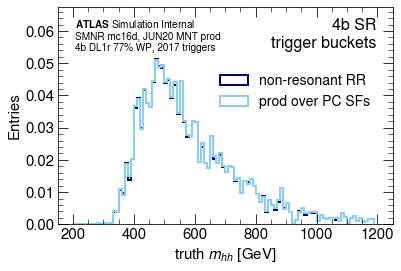

In [86]:
nb = 100
r = (200,1200)

for df, c, l in zip([dR1_orig,dR1],
                    ['navy','lightskyblue'],
                    ['non-resonant RR','prod over PC SFs']):

    
    m = (df.ntag >= 4) & (df.abs_deta_hh > 1.5) & (df.X_wt > 1.5) & (df.kinematic_region == 0) & (df.bucket != 0)
    
    plt.hist(df.loc[m,'truth_mhh'],nb,r,label=l,histtype='step',color=c,lw=2,
             weights=df.loc[m,'mc_sf'])
    
plt.xlabel('truth $m_{hh}$ [GeV]')
plt.ylabel('Entries')
plt.legend(loc='upper right',bbox_to_anchor=(0.97,.75))

_,ymax= plt.ylim()
plt.ylim(0,1.25*ymax)

ax = plt.gca()
plt.text(0.05,0.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=10)
plt.text(0.95,0.95,'4b SR\ntrigger buckets',ha='right',va='top',transform=ax.transAxes,fontsize=16)



plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}/truth_mhh_4b_jetSort_SR_buckets.pdf',bbox_inches='tight')
plt.show()

And finally w/ reco $m_{hh}$

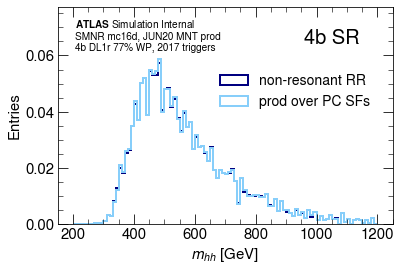

In [85]:
nb = 100
r = (200,1200)

for df, c, l in zip([dR1_orig,dR1],
                    ['navy','lightskyblue'],
                    ['non-resonant RR','prod over PC SFs']):

    
    m = (df.ntag >= 4) & (df.abs_deta_hh > 1.5) & (df.X_wt > 1.5) & (df.kinematic_region == 0)
    
    plt.hist(df.loc[m,'m_hh'],nb,r,label=l,histtype='step',color=c,lw=2,
             weights=df.loc[m,'mc_sf'])
    
plt.xlabel('$m_{hh}$ [GeV]')
plt.ylabel('Entries')
plt.legend(loc='upper right',bbox_to_anchor=(0.97,.75))

_,ymax= plt.ylim()
plt.ylim(0,1.25*ymax)

ax = plt.gca()
plt.text(0.05,0.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=10)
plt.text(0.9,0.9,'4b SR',ha='right',va='top',transform=ax.transAxes,fontsize=20)

plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}/m_hh_4b_jetSort_SR.pdf',bbox_inches='tight')
plt.show()

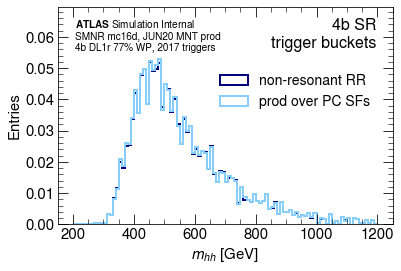

In [84]:
nb = 100
r = (200,1200)

for df, c, l in zip([dR1_orig,dR1],
                    ['navy','lightskyblue'],
                    ['non-resonant RR','prod over PC SFs']):

    
    m = (df.ntag >= 4) & (df.abs_deta_hh > 1.5) & (df.X_wt > 1.5) & (df.kinematic_region == 0) & (df.bucket != 0)
    
    plt.hist(df.loc[m,'m_hh'],nb,r,label=l,histtype='step',color=c,lw=2,
             weights=df.loc[m,'mc_sf'])
    
plt.xlabel('$m_{hh}$ [GeV]')
plt.ylabel('Entries')
plt.legend(loc='upper right',bbox_to_anchor=(0.97,.75))

_,ymax= plt.ylim()
plt.ylim(0,1.25*ymax)

ax = plt.gca()
plt.text(0.05,0.95,text,ha='left',va='top',transform=ax.transAxes,fontsize=10)
plt.text(0.95,0.95,'4b SR\ntrigger buckets',ha='right',va='top',transform=ax.transAxes,fontsize=16)

plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}/m_hh_4b_jetSort_SR_buckets.pdf',bbox_inches='tight')
plt.show()

## Step 1: Jet selection accuracies <a name="jetAcc">

In [6]:
from postprocess import redoSort

In [4]:
# Load in the pag files
nSelectedJets = 5

pag_Db   = pd.read_parquet(f'../data/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/df_preLN_lr_0p003_3b_Db_sort.parquet')
pag_btag = pd.read_parquet(f'../data/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/df_btag_5j_3b_Db_sort.parquet')

In [8]:
pag_Db = redoSort(pag_Db)
pag_btag = redoSort(pag_btag)

In [33]:
for c in pag_Db.columns:
    print(c)

run_number
event_number
mc_sf
ntag
cosThetaStar
kinematic_region
m_hh
m_hh_cor
chosenPair
HT
MDR
MDpT
abs_deta_hh
Xhh
HT_all
lead_pt
lead_tag
bucket
pT_h1
eta_h1
phi_h1
m_h1
dRjj_h1
dPhi_h1
pT_h2
eta_h2
phi_h2
m_h2
dRjj_h2
dPhi_h2
Db_h1_j1
Db_h1_j2
Db_h2_j1
Db_h2_j2
njets
pT_2
pT_4
eta_i
dRjj_1
dRjj_2
pt_hh
X_wt
X_wt_old
correctPair
sameParent
unique
dRmatch
goodJets
truth_mhh
truth_pthh
h0_pt
h0_eta
h0_phi
h0_barcode
h1_pt
h1_eta
h1_phi
h1_barcode
b0_pt
b0_eta
b0_phi
b0_parent_barcode
b0_jidx
b0_drMatch
b1_pt
b1_eta
b1_phi
b1_parent_barcode
b1_jidx
b1_drMatch
b2_pt
b2_eta
b2_phi
b2_parent_barcode
b2_jidx
b2_drMatch
b3_pt
b3_eta
b3_phi
b3_parent_barcode
b3_jidx
b3_drMatch
j0_Db
j0_bidx
j0_drMatch
j1_Db
j1_bidx
j1_drMatch
j2_Db
j2_bidx
j2_drMatch
j3_Db
j3_bidx
j3_drMatch
j4_Db
j4_bidx
j4_drMatch
ntag_pag
max_prob
idx_h1_j1
idx_h1_j2
idx_h2_j1
idx_h2_j2
HLT_2j15_gsc35_bmv2c1040_split_2j15_gsc35_boffperf_split_L14J15.0ETA25
HLT_2j35_gsc55_bmv2c1050_split_ht300_L1HT190-J15s5.ETA21
HLT_j110

**Personal reminder:** *Which* are the relevant columns for determining if pag got the right jets?

In [20]:
pag_Db[['idx_h1_j1','idx_h1_j2','idx_h2_j1','idx_h2_j2']].head()

idx_h1_j1  idx_h1_j2  idx_h2_j1  idx_h2_j2
entry                                            
1              0          2          3          1
3              0          3          1          2
7              1          2          0          3
10             0          3          1          2
13             1          2          0          3

In [24]:
pag_Db[[f'b{bi}_jidx' for bi in range(4)]].head()

b0_jidx  b1_jidx  b2_jidx  b3_jidx
entry                                    
1            0        3        1        2
3            0        1        2        3
7            0        1        2        3
10           0        1        2        3
13           0        1        2        3

Alright - the `idx_h{1,2}_j{1,2}` columns save which jets were chosen by pairAGraph and the `b{0,1,2,3}_jidx` store which jets are matched to the corresponding $b$-quarks.

In [14]:
# Add a new column onto the df
for df in [pag_Db, pag_btag]:

    # Add a new column onto the df
    hc_idx = df[[f'idx_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values
    b_idx  =  df[[f'b{i}_jidx' for i in range(4)]].values

    df['correctJets'] = np.sum(np.sort(hc_idx,axis=1) == np.sort(b_idx,axis=1),axis=1)==4

In [15]:
def jetAcc_2cat(dfs):
    '''
    '''
    
    cs = ['Db','b-tag']
    idxs = ['4b','3b']
    jetSel = pd.DataFrame(0,index=['all']+[f'{i}{t}' for i,t in product(idxs,['',' (pag)'])],
                          columns=cs)

    for ci,df in zip(cs,[pag_Db, pag_btag]):

        dmask = (df.correctPair != -1)
        nmask = df.correctJets & dmask

        num = np.sum(df.loc[nmask,'mc_sf'])
        den = np.sum(df.loc[dmask,'mc_sf'])

        jetSel.loc['all',ci] = num / den

        for i, mi in zip(idxs,[df.ntag >= 4, (df.ntag == 3)]):    
            num = np.sum(df.loc[nmask & mi,'mc_sf'])
            den = np.sum(df.loc[dmask & mi,'mc_sf'])

            jetSel.loc[i,ci] = num / den

        for i, mi in zip(idxs,[df.ntag_pag >= 4, df.ntag_pag == 3]):    
            num = np.sum(df.loc[nmask & mi,'mc_sf'])
            den = np.sum(df.loc[dmask & mi,'mc_sf'])

            jetSel.loc[f'{i} (pag)',ci] = num / den
        
    return jetSel

In [16]:
def jetAcc_3cat(dfs):
    '''
    Goal: Compare the jet selection accuracies b/w three 
    b-tagging categories:
    1. 4b
    2. 3b + 1 loose
    3. 3b
    
    Inputs same as jetAcc_2cat
    '''
    cs = ['Db','b-tag']
    idxs = ['4b','3b + 1 loose','3b']
    jetSel = pd.DataFrame(0,index=['all']+[f'{i}{t}' for i,t in product(idxs,['',' (pag)'])],
                          columns=cs)


    for ci,df in zip(cs,dfs):

        dmask = (df.correctPair != -1)
        nmask = df.correctJets & dmask

        num = np.sum(df.loc[nmask,'mc_sf'])
        den = np.sum(df.loc[dmask,'mc_sf'])

        jetSel.loc['all',ci] = num / den

        for i, mi in zip(idxs,[df.ntag >= 4, (df.ntag == 3) & (df.j3_Db==2), (df.ntag == 3) & (df.j3_Db==1)]):    
            num = np.sum(df.loc[nmask & mi,'mc_sf'])
            den = np.sum(df.loc[dmask & mi,'mc_sf'])

            jetSel.loc[i,ci] = num / den

        Db_min_pag = np.min(df[[f'Db_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,axis=1)
        for i, mi in zip(idxs,[df.ntag_pag >= 4, (df.ntag_pag == 3) & (Db_min_pag==2), (df.ntag_pag == 3) & (Db_min_pag==1)]):    
            num = np.sum(df.loc[nmask & mi,'mc_sf'])
            den = np.sum(df.loc[dmask & mi,'mc_sf'])

            jetSel.loc[f'{i} (pag)',ci] = num / den
        
    return jetSel

In [17]:
jetSel_2cat = jetAcc_2cat([pag_Db, pag_btag])

jetSel_2cat.round(3)

Db  b-tag
all       0.947  0.937
4b        0.961  0.959
4b (pag)  0.968  0.964
3b        0.932  0.913
3b (pag)  0.927  0.910

In [18]:
jetSel_3cat = jetAcc_3cat([pag_Db, pag_btag])

jetSel_3cat.round(3)

Db  b-tag
all                 0.947  0.937
4b                  0.961  0.959
4b (pag)            0.968  0.964
3b + 1 loose        0.956  0.906
3b + 1 loose (pag)  0.957  0.976
3b                  0.919  0.917
3b (pag)            0.911  0.880

Ok, although it's great that this is pretty high, remember the "name of the game" with 3b is *all* about the background rejection.

Also - they're still pretty similar for 3b as well, so maybe the $D_b$ sort is having a bigger impact than I was thinking?

**Note:** It *doesn't* make sense to have a 3b + 1 loose category if I'm only using the b-tag feature and not $Q_b$.

**Open Q:** How similar is the bkg rejection for the 3b vs 3b + 1 loose categories for these 2 trainings??

**It might be nice to make some $m_{4j}$ plots showing the *extra* signal efficiency we gain with pairAGraph??**

**Oh - I could *also* do with the resonant trigger buckets?**

## Step 2: Pairing accuracy <a name="pairingAcc">
    
    
It might be worthwhile to have a quick look at the SM and the ... cateogries too??

In [19]:
for df in [dR1, pag_Db, pag_btag]:

    dmask = (df.correctPair != -1)
    nmask = (df.correctPair == df.chosenPair) & dmask

    num = np.sum(df.loc[nmask,'mc_sf'])
    den = np.sum(df.loc[dmask,'mc_sf'])

    print(num / den)
    

0.8892052079184373
0.9178984356403288
0.9066546180520901


Ok - for now I'll just look at the cutflow for `ntag_pag`, if I decide it's important later I can look at `ntag` as well.

In [22]:
def pairingCutFlow_2cat():
    
    cs = ['Db','b-tag']
    idxs = ['4b','3b']
    accs = pd.DataFrame(0,index=[f'{i}: {t}' for i,t in product(idxs,cs)],
                        columns=['pairing','deta_hh','X_wt','SR','VR','CR'])

    for ci,df in zip(cs,[pag_Db, pag_btag]):

        for i, ntag, ntag_mask in zip(idxs,[4,3],[df.ntag_pag >= 4, (df.ntag_pag == 3)]):   
        
            key = f'{i}: {ci}'
        
            dmask = (df.correctPair != -1) & ntag_mask
            nmask = (df.chosenPair == df.correctPair) & dmask

            num = np.sum(df.loc[nmask & ntag,'mc_sf'])
            den = np.sum(df.loc[dmask & ntag,'mc_sf'])

            accs.loc[key,'pairing'] = num / den
        
        
            deta_cut = (df.abs_deta_hh < 1.5)
            Xwt_cut = deta_cut & (df.X_wt > 1.5)
            SR = Xwt_cut & (df.kinematic_region==0)
            VR = Xwt_cut & (df.kinematic_region==1)
            CR = Xwt_cut & (df.kinematic_region==2)
            
            for cut, mi in zip(['deta_hh','X_wt','SR','VR','CR'],[deta_cut,Xwt_cut,SR,VR,CR]):
         
                num = np.sum(df.loc[nmask & mi,'mc_sf'])
                den = np.sum(df.loc[dmask & mi,'mc_sf'])

                accs.loc[key,cut] = num / den

    return accs

In [23]:
pairingCutFlow_2cat()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


pairing   deta_hh      X_wt        SR        VR        CR
4b: Db          NaN  0.938999  0.954382  0.985917  0.968297  0.913192
4b: b-tag       NaN  0.934071  0.951224  0.985189  0.968284  0.908551
3b: Db     0.900638  0.906090  0.925501  0.973834  0.953120  0.878029
3b: b-tag  0.883000  0.889629  0.910575  0.968123  0.943352  0.857912

Woah - the accuracy is even pretty high in the VR and CR, I guess this is b/c we're only considering cases where the correct pair exists???

In [26]:
def pairingCutFlow_3cat():
    
    cs = ['Db','b-tag']
    idxs = ['4b','3b + 1 loose','3b']
    accs = pd.DataFrame(0,index=[f'{i}: {t}' for i,t in product(idxs,cs)],
                        columns=['pairing','deta_hh','X_wt','SR','VR','CR'])

    for ci,df in zip(cs,[pag_Db, pag_btag]):

        Db_min_pag = np.min(df[[f'Db_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,axis=1)
        for i, ntag,ntag_mask in zip(idxs,[4,3,3],
                         [df.ntag_pag >= 4, 
                          (df.ntag_pag == 3) & (Db_min_pag==2), 
                          (df.ntag_pag == 3) & (Db_min_pag==1)]):     
        
            key = f'{i}: {ci}'
        
            dmask = (df.correctPair != -1) & ntag_mask
            nmask = (df.chosenPair == df.correctPair) & dmask

            num = np.sum(df.loc[nmask & ntag,'mc_sf'])
            den = np.sum(df.loc[dmask & ntag,'mc_sf'])

            accs.loc[key,'pairing'] = num / den
        
        
            deta_cut = (df.abs_deta_hh < 1.5)
            Xwt_cut = deta_cut & (df.X_wt > 1.5)
            SR = Xwt_cut & (df.kinematic_region==0)
            VR = Xwt_cut & (df.kinematic_region==1)
            CR = Xwt_cut & (df.kinematic_region==2)
            
            for cut, mi in zip(['deta_hh','X_wt','SR','VR','CR'],[deta_cut,Xwt_cut,SR,VR,CR]):
         
                num = np.sum(df.loc[nmask & mi,'mc_sf'])
                den = np.sum(df.loc[dmask & mi,'mc_sf'])

                accs.loc[key,cut] = num / den

    return accs

In [27]:
pairingCutFlow_3cat()

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


pairing   deta_hh      X_wt        SR        VR  \
4b: Db                    NaN  0.938999  0.954382  0.985917  0.968297   
4b: b-tag                 NaN  0.934071  0.951224  0.985189  0.968284   
3b + 1 loose: Db     0.930700  0.935374  0.949694  0.981563  0.972530   
3b + 1 loose: b-tag  0.949176  0.952689  0.962182  0.985578  0.978159   
3b: Db               0.884895  0.890706  0.912830  0.969493  0.943364   
3b: b-tag            0.852484  0.860099  0.885965  0.958841  0.927160   

                           CR  
4b: Db               0.913192  
4b: b-tag            0.908551  
3b + 1 loose: Db     0.912096  
3b + 1 loose: b-tag  0.929944  
3b: Db               0.860740  
3b: b-tag            0.826281

## Step 3: Comparison of the SR optimization <a name="srOpt">

**Pre-step:** Draw some of the *signal* massplanes, since TJ suggested that this would be a good idea too!!

(Maybe including $\kappa_\lambda$ = 5 or 10 as well might be useful to get a handle on the massplane dependence??)

In [28]:
fmp = "$\mathbf{ATLAS}$ Simulation Internal\n"
fmp += f"{physicsSample} {mc}, {prodTag} MNT prod\n"
fmp += "DL1r 77% WP, $|\Delta \eta_{hh}|$ < 1.5, $X_{wt}$ > 1.5"

In [29]:
x0, y0 = 120,110
x1,y1 = 125,116

SR_x_new = np.linspace(x1 / 1.16, x1 / 0.840000000001)

alpha = np.power(10*(SR_x_new - x1)/SR_x_new,2)
SR_y1_new = y1 / (1 + 0.1 * np.sqrt(np.power(1.6,2) - alpha))
SR_y2_new = y1 / (1 - 0.1 * np.sqrt(np.power(1.6,2) - alpha))

# For choices - see min-dR validation nb
CR_x_new = np.linspace(x1-30,x1+30)
beta = np.sqrt(30**2 - np.power(CR_x_new-x1, 2))
CR_y1_new = y1 + beta
CR_y2_new = y1 - beta

SB_x_new = np.linspace(x1*1.01-45,x1*1.01+45)
gamma = np.sqrt(45**2 - np.power(SB_x_new-x1*1.01, 2))
SB_y1_new = y1*1.01 + gamma
SB_y2_new = y1*1.01 - gamma


In [11]:
# for c in dR1.columns:
#     print(c)

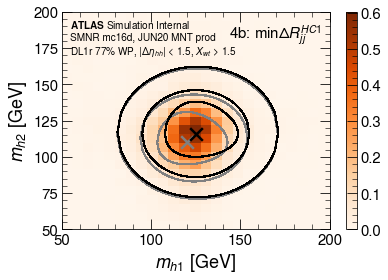

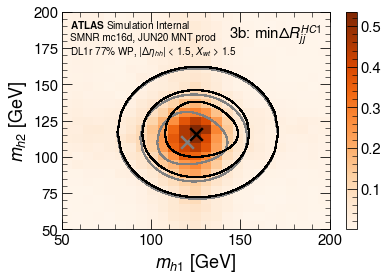

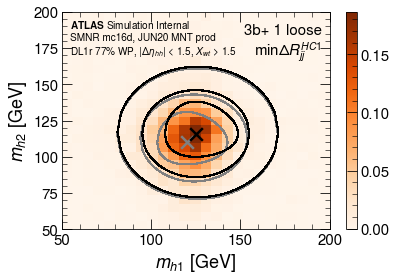

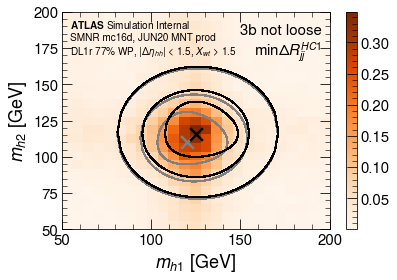

In [32]:
df, cmap  = dR1, 'Oranges'
    
c0 = 'grey'
c1 = 'k'
    
title = '$\min \Delta R_{jj}^{HC 1}$'
    
for ntag, mi,titleTag,tag in zip([4,3,3,3],
                                 [(df.ntag>=4),(df.ntag==3),(df.ntag==3)&(df.j3_Db==2),(df.ntag==3)&(df.j3_Db==1)],
                                 ['','','+ 1 loose',' not loose'],['','','loose','notLoose']):
    
    m = mi & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    plt.figure()
    plt.hist2d(df.loc[m,'m_h1'],df.loc[m,'m_h2'],25,[(50,200),(50,200)],
               cmap=cmap,weights=df.loc[m,'mc_sf'])
    plt.colorbar()
    plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
    plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)
    
    ax = plt.gca()
    my_title = f'{ntag}b: {title}' if tag == '' else f'{ntag}b{titleTag}\n{title}'
    plt.text(.97,.95,my_title,transform=ax.transAxes,ha='right',va='top',fontsize=15)
    plt.text(0.03,0.97,fmp,transform=ax.transAxes,ha='left',va='top',fontsize=10)
    
    # Overlay our region definitions
    plt.scatter([x0],[y0],160,marker='x',color=c0)
    plt.plot(np.hstack([SR_x,SR_x[::-1]]),np.hstack([SR_y1,SR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([CR_x,CR_x[::-1]]),np.hstack([CR_y1,CR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([SB_x,SB_x[::-1]]),np.hstack([SB_y1,SB_y2[::-1]]),color=c0,lw=1.2)
        
        
    plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}/mp_{ntag}b{tag}_Xwt.pdf',
                bbox_inches='tight')
        
    plt.scatter([x1],[y1],160,marker='x',color=c1)    
    plt.plot(np.hstack([SR_x_new,SR_x_new[::-1]]),
             np.hstack([SR_y1_new,SR_y2_new[::-1]]),
             color=c1,lw=1.2)
    plt.plot(np.hstack([CR_x_new,CR_x_new[::-1]]),
             np.hstack([CR_y1_new,CR_y2_new[::-1]]),
             color=c1,lw=1.2)
    plt.plot(np.hstack([SB_x_new,SB_x_new[::-1]]),
             np.hstack([SB_y1_new,SB_y2_new[::-1]]),
             color=c1,lw=1.2)
        
plt.show()

Ok - I like the way these look!!

**$\mathrm{\mathbb{P}}$: Db** with the *exclusive* 3b categories

In [34]:
for df in [pag_Db, pag_btag]:
    df['minQ'] = np.min(df[[f'Db_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,axis=1)

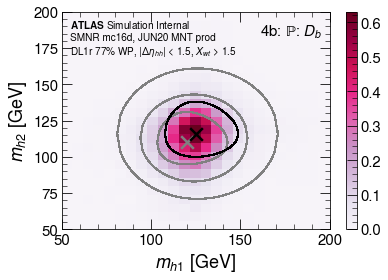

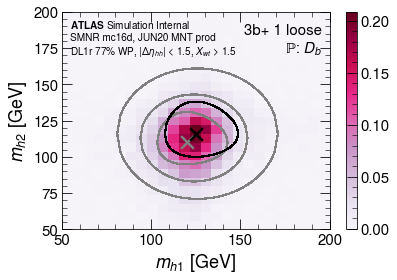

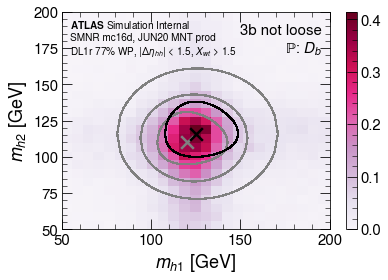

In [40]:
df, cmap, title = pag_Db, 'PuRd', '$\mathrm{\mathbb{P}}$: $D_b$'

for ntag, mi,titleTag,tag in zip([4,3,3], [(df.ntag_pag==4),(df.minQ==2),(df.minQ==1)],
                                 ['','+ 1 loose',' not loose'],['','loose','notLoose']):
    m = (df.ntag_pag==ntag) & mi & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    plt.figure()
    plt.hist2d(df.loc[m,'m_h1'],df.loc[m,'m_h2'],25,[(50,200),(50,200)],
               cmap=cmap,weights=df.loc[m,'mc_sf'])
    plt.colorbar()
    plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
    plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)

    ax = plt.gca()
    my_title = f'{ntag}b: {title}' if tag == '' else f'{ntag}b{titleTag}\n{title}'
    plt.text(.97,.95,my_title,transform=ax.transAxes,ha='right',va='top',fontsize=15)
    plt.text(0.03,0.97,fmp,transform=ax.transAxes,ha='left',va='top',fontsize=10)

    # Overlay our region definitions
    plt.scatter([x0],[y0],160,marker='x',color=c0)

    plt.plot(np.hstack([SR_x,SR_x[::-1]]),np.hstack([SR_y1,SR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([CR_x,CR_x[::-1]]),np.hstack([CR_y1,CR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([SB_x,SB_x[::-1]]),np.hstack([SB_y1,SB_y2[::-1]]),color=c0,lw=1.2)

    plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/preLN_lr_0p003/mp_{ntag}b{tag}_Xwt.pdf',
                bbox_inches='tight')
    
    # And add some new curves too!
    plt.scatter([x1],[y1],160,marker='x',color=c1)    
    plt.plot(np.hstack([SR_x_new,SR_x_new[::-1]]),
             np.hstack([SR_y1_new,SR_y2_new[::-1]]),
             color=c1,lw=1.2)
        
plt.show()

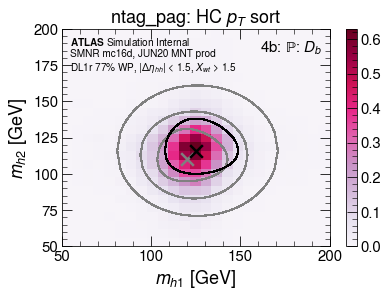

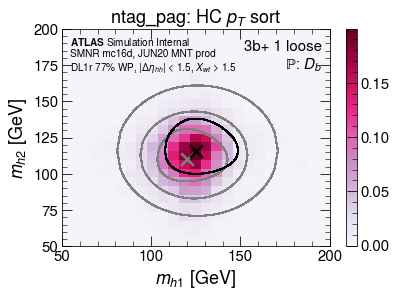

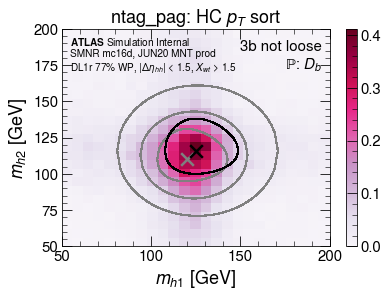

In [43]:
df, cmap, title = pag_Db, 'PuRd', '$\mathrm{\mathbb{P}}$: $D_b$'

for ntag, mi,titleTag,tag in zip([4,3,3], [(df.ntag_pag==4),(df.minQ==2),(df.minQ==1)],
                                 ['','+ 1 loose',' not loose'],['','loose','notLoose']):
    m = (df.ntag_pag==ntag) & mi & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    plt.figure()
    plt.hist2d(df.loc[m,'m_lead'],df.loc[m,'m_subl'],25,[(50,200),(50,200)],
               cmap=cmap,weights=df.loc[m,'mc_sf'])
    plt.colorbar()
    plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
    plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)

    ax = plt.gca()
    my_title = f'{ntag}b: {title}' if tag == '' else f'{ntag}b{titleTag}\n{title}'
    plt.text(.97,.95,my_title,transform=ax.transAxes,ha='right',va='top',fontsize=15)
    plt.text(0.03,0.97,fmp,transform=ax.transAxes,ha='left',va='top',fontsize=10)
    plt.title('ntag_pag: HC $p_T$ sort')
    
    # Overlay our region definitions
    plt.scatter([x0],[y0],160,marker='x',color=c0)

    plt.plot(np.hstack([SR_x,SR_x[::-1]]),np.hstack([SR_y1,SR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([CR_x,CR_x[::-1]]),np.hstack([CR_y1,CR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([SB_x,SB_x[::-1]]),np.hstack([SB_y1,SB_y2[::-1]]),color=c0,lw=1.2)

    plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/preLN_lr_0p003/mp_{ntag}b{tag}_Xwt_hcSort.pdf',
                bbox_inches='tight')
    
    # And add some new curves too!
    plt.scatter([x1],[y1],160,marker='x',color=c1)    
    plt.plot(np.hstack([SR_x_new,SR_x_new[::-1]]),
             np.hstack([SR_y1_new,SR_y2_new[::-1]]),
             color=c1,lw=1.2)
        
plt.show()

**$\mathrm{\mathbb{P}}$: b-tag** with a single *inclusive* 3b category

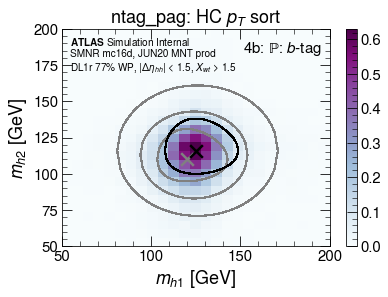

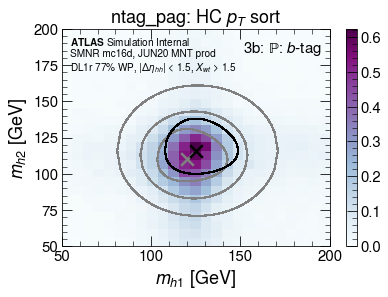

In [45]:
df, cmap, title = pag_btag, 'BuPu', '$\mathrm{\mathbb{P}}$: $b$-tag'

for ntag in [4,3]:
    m = (df.ntag_pag==ntag) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    plt.figure()
    plt.hist2d(df.loc[m,'m_h1'],df.loc[m,'m_h2'],25,[(50,200),(50,200)],
               cmap=cmap,weights=df.loc[m,'mc_sf'])
    plt.colorbar()
    plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
    plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)

    ax = plt.gca()
    plt.text(.97,.95,f'{ntag}b: {title}',transform=ax.transAxes,ha='right',va='top',fontsize=15)
    plt.text(0.03,0.97,fmp,transform=ax.transAxes,ha='left',va='top',fontsize=10)
    
    # Overlay our region definitions
    plt.scatter([120],[110],160,marker='x',color=c0)

    plt.plot(np.hstack([SR_x,SR_x[::-1]]),np.hstack([SR_y1,SR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([CR_x,CR_x[::-1]]),np.hstack([CR_y1,CR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([SB_x,SB_x[::-1]]),np.hstack([SB_y1,SB_y2[::-1]]),color=c0,lw=1.2)

    plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/btag_5j/mp_{ntag}b{tag}_Xwt.pdf',
            bbox_inches='tight')

    # And add some new curves too!
    plt.scatter([x1],[y1],160,marker='x',color=c1)    
    plt.plot(np.hstack([SR_x_new,SR_x_new[::-1]]),
             np.hstack([SR_y1_new,SR_y2_new[::-1]]),
             color=c1,lw=1.2)
        
plt.show()

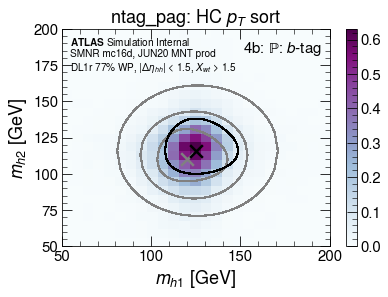

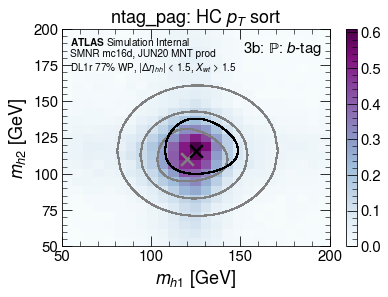

In [46]:
df, cmap, title = pag_btag, 'BuPu', '$\mathrm{\mathbb{P}}$: $b$-tag'

for ntag in [4,3]:
    m = (df.ntag_pag==ntag) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    plt.figure()
    plt.hist2d(df.loc[m,'m_lead'],df.loc[m,'m_subl'],25,[(50,200),(50,200)],
               cmap=cmap,weights=df.loc[m,'mc_sf'])
    plt.colorbar()
    plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
    plt.ylabel('$m_{h2}$ [GeV]',fontsize=18)

    ax = plt.gca()
    plt.text(.97,.95,f'{ntag}b: {title}',transform=ax.transAxes,ha='right',va='top',fontsize=15)
    plt.text(0.03,0.97,fmp,transform=ax.transAxes,ha='left',va='top',fontsize=10)
    plt.title('ntag_pag: HC $p_T$ sort')
    
    # Overlay our region definitions
    plt.scatter([120],[110],160,marker='x',color=c0)

    plt.plot(np.hstack([SR_x,SR_x[::-1]]),np.hstack([SR_y1,SR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([CR_x,CR_x[::-1]]),np.hstack([CR_y1,CR_y2[::-1]]),color=c0,lw=1.2)
    plt.plot(np.hstack([SB_x,SB_x[::-1]]),np.hstack([SB_y1,SB_y2[::-1]]),color=c0,lw=1.2)

    plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/btag_5j/mp_{ntag}b{tag}_Xwt.pdf',
            bbox_inches='tight')

    # And add some new curves too!
    plt.scatter([x1],[y1],160,marker='x',color=c1)    
    plt.plot(np.hstack([SR_x_new,SR_x_new[::-1]]),
             np.hstack([SR_y1_new,SR_y2_new[::-1]]),
             color=c1,lw=1.2)
        
plt.show()

To me - it seems like we can gain from shifting the SR *up*, no??

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


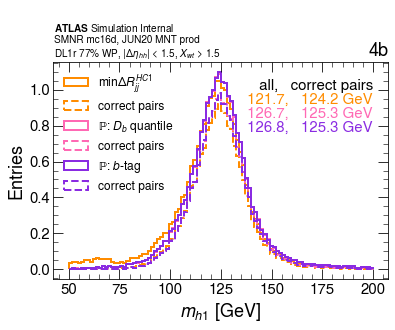

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


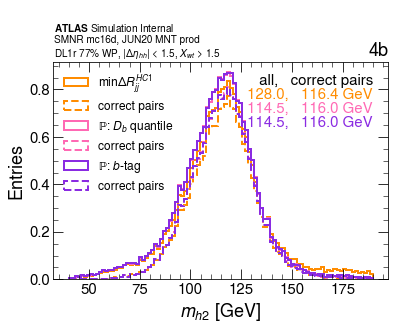

In [19]:
m1_text = ['all,   correct pairs']
m2_text = ['all,   correct pairs']

m1_str, m2_str = '$m_{h1}$','$m_{h2}$'

colors = ['k','darkorange','hotpink','blueviolet']

for df,color,ntag,l in zip([dR1,pag_Db,pag_btag],colors[1:],['ntag','ntag_pag','ntag_pag'],
                              ['$\min \Delta R_{jj}^{HC 1}$','$\mathrm{\mathbb{P}}$: $D_b$ quantile','$\mathrm{\mathbb{P}}$: $b$-tag']):
        
    m = (df[ntag]>=4) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    plt.figure(1)
    plt.hist(df.loc[m,'m_h1'],100,(50,200),weights=df.loc[m,'mc_sf'],
             color=color,histtype='step',lw=2,label=l)
    plt.hist(df.loc[m & (df.chosenPair==df.correctPair),'m_h1'],100,(50,200),
             weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'],
             color=color,histtype='step',lw=2,ls='--', label='correct pairs')
        
    # m1 means
    mi = m&(df.chosenPair==df.correctPair)
    
    m1_mean = np.sum(df.loc[m,'m_h1']*df.loc[m,'mc_sf'])/np.sum(df.loc[m,'mc_sf'])
    m1_correct = np.sum(df.loc[mi,'m_h1']*df.loc[mi,'mc_sf'])/np.sum(df.loc[mi,'mc_sf'])
    
    m1_text.append(f'{m1_mean:.1f},   {m1_correct:.1f} GeV')

    plt.figure(2)
    plt.hist(df.loc[m,'m_h2'],100,(40,190),weights=df.loc[m,'mc_sf'],
             color=color,histtype='step',lw=2,label=l)
    plt.hist(df.loc[m & (df.chosenPair==df.correctPair),'m_h2'],100,(40,190),
             weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'],
             color=color,histtype='step',lw=2,ls='--', label='correct pairs')
    
    # m2 means
    m2_mean = np.sum(df.loc[m,'m_h2']*df.loc[m,'mc_sf'])/np.sum(df.loc[m,'mc_sf'])
    m2_correct = np.sum(df.loc[mi,'m_h2']*df.loc[mi,'mc_sf'])/np.sum(df.loc[mi,'mc_sf'])
    m2_text.append(f'{m2_mean:.1f},   {m2_correct:.1f} GeV')


for i, xloc,yloc, txt, xl in zip([1,2],[200,190],[1,.82], [m1_text, m2_text], ['$m_{h1}$ [GeV]','$m_{h2}$ [GeV]']):  
    rainbow_text(xloc, yloc, txt, colors,ax=plt.figure(i).gca(), yoffset=1,ha='right')
    plt.legend(loc='upper left',fontsize=12)
    
    plt.xlabel(xl,fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.title('4b',loc='right')
    
    plt.text(0,1.07,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
    
    plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/m_h{i}_fullmassplane_4b.pdf',
                bbox_inches='tight')

plt.show()

By eye, it seems like taking the mean of the *correct pairs* is a better bet than taking the mean of everything.

Not surprisingly, there's *no* difference for 4b for the 2 different pairAGraph trainings.

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


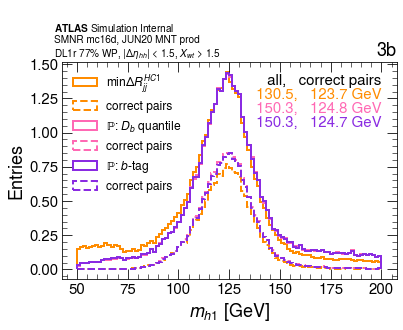

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


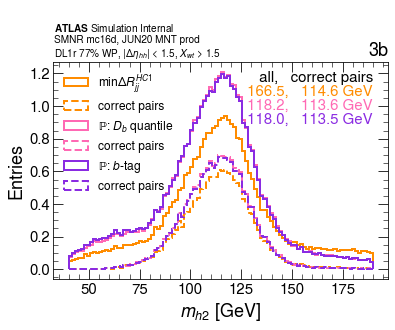

In [23]:
m1_text = ['all,   correct pairs']
m2_text = ['all,   correct pairs']

for df,color,ntag,l in zip([dR1,pag_Db,pag_btag],colors[1:],['ntag','ntag_pag','ntag_pag'],
                           ['$\min \Delta R_{jj}^{HC 1}$','$\mathrm{\mathbb{P}}$: $D_b$ quantile','$\mathrm{\mathbb{P}}$: $b$-tag']):
        
    m = (df[ntag]==3) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    plt.figure(1)
    plt.hist(df.loc[m,'m_h1'],100,(50,200),weights=df.loc[m,'mc_sf'],
             color=color,histtype='step',lw=2,label=l)
    plt.hist(df.loc[m & (df.chosenPair==df.correctPair),'m_h1'],100,(50,200),
             weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'],
             color=color,histtype='step',lw=2,ls='--', label='correct pairs')
        
    # m1 means
    mi = m&(df.chosenPair==df.correctPair)
    
    m1_mean = np.sum(df.loc[m,'m_h1']*df.loc[m,'mc_sf'])/np.sum(df.loc[m,'mc_sf'])
    m1_correct = np.sum(df.loc[mi,'m_h1']*df.loc[mi,'mc_sf'])/np.sum(df.loc[mi,'mc_sf'])
    
    m1_text.append(f'{m1_mean:.1f},   {m1_correct:.1f} GeV')

    plt.figure(2)
    plt.hist(df.loc[m,'m_h2'],100,(40,190),weights=df.loc[m,'mc_sf'],
             color=color,histtype='step',lw=2,label=l)
    plt.hist(df.loc[m & (df.chosenPair==df.correctPair),'m_h2'],100,(40,190),
             weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'],
             color=color,histtype='step',lw=2,ls='--', label='correct pairs')
    
    # m2 means
    m2_mean = np.sum(df.loc[m,'m_h2']*df.loc[m,'mc_sf'])/np.sum(df.loc[m,'mc_sf'])
    m2_correct = np.sum(df.loc[mi,'m_h2']*df.loc[mi,'mc_sf'])/np.sum(df.loc[mi,'mc_sf'])
    m2_text.append(f'{m2_mean:.1f},   {m2_correct:.1f} GeV')


for i, xloc,yloc, txt, xl in zip([1,2],[200,190],[1.35,1.15], [m1_text, m2_text], ['$m_{h1}$ [GeV]','$m_{h2}$ [GeV]']):  
    rainbow_text(xloc, yloc, txt, colors,ax=plt.figure(i).gca(), yoffset=1,ha='right')
    plt.legend(loc='upper left',fontsize=12)
    
    plt.xlabel(xl,fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.title('3b',loc='right')
    
    plt.text(0,1.07,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
    
    plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/m_h{i}_fullmassplane_3b.pdf',
                bbox_inches='tight')

plt.show()

**Break the purple curve down into 3b + loose and 3b not loose?**

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a 

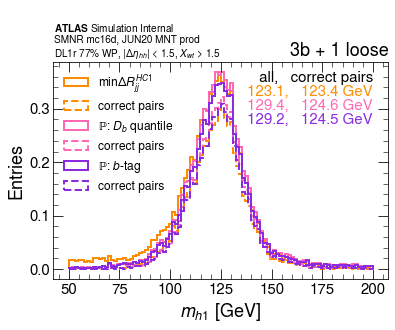

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


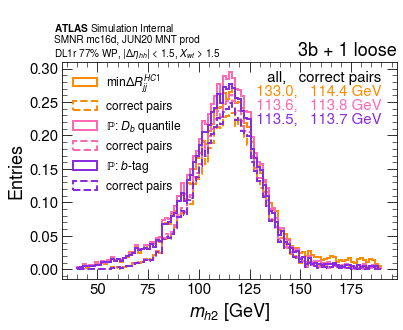

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


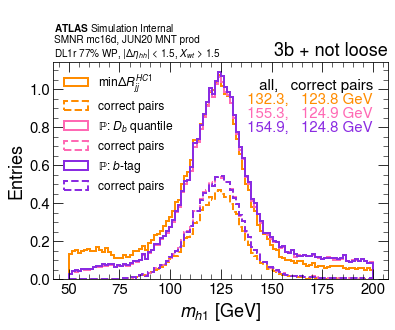

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


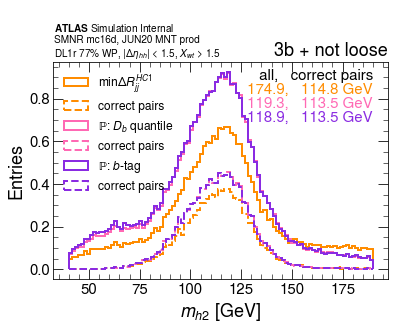

In [35]:
m1_text = ['all,   correct pairs']
m2_text = ['all,   correct pairs']

for min_quantile,title,fig1,fig2 in zip([2,1],['3b + 1 loose','3b not loose'],[1,3],[2,4]):

    for df,color,ntag,l in zip([dR1,pag_Db,pag_btag],colors[1:],['ntag','ntag_pag','ntag_pag'],
                               ['$\min \Delta R_{jj}^{HC 1}$','$\mathrm{\mathbb{P}}$: $D_b$ quantile','$\mathrm{\mathbb{P}}$: $b$-tag']):
        
        Db_min_pag = np.min(df[[f'Db_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,axis=1)
        m = (df[ntag]==3) & (Db_min_pag == min_quantile) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)
        
        plt.figure(fig1)
        plt.hist(df.loc[m,'m_h1'],100,(50,200),weights=df.loc[m,'mc_sf'],
                 color=color,histtype='step',lw=2,label=l)
        plt.hist(df.loc[m & (df.chosenPair==df.correctPair),'m_h1'],100,(50,200),
                 weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'],
                 color=color,histtype='step',lw=2,ls='--', label='correct pairs')

        # m1 means
        mi = m&(df.chosenPair==df.correctPair)

        m1_mean = np.sum(df.loc[m,'m_h1']*df.loc[m,'mc_sf'])/np.sum(df.loc[m,'mc_sf'])
        m1_correct = np.sum(df.loc[mi,'m_h1']*df.loc[mi,'mc_sf'])/np.sum(df.loc[mi,'mc_sf'])

        m1_text.append(f'{m1_mean:.1f},   {m1_correct:.1f} GeV')

        plt.figure(fig2)
        plt.hist(df.loc[m,'m_h2'],100,(40,190),weights=df.loc[m,'mc_sf'],
                 color=color,histtype='step',lw=2,label=l)
        plt.hist(df.loc[m & (df.chosenPair==df.correctPair),'m_h2'],100,(40,190),
                 weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'],
                 color=color,histtype='step',lw=2,ls='--', label='correct pairs')

        # m2 means
        m2_mean = np.sum(df.loc[m,'m_h2']*df.loc[m,'mc_sf'])/np.sum(df.loc[m,'mc_sf'])
        m2_correct = np.sum(df.loc[mi,'m_h2']*df.loc[mi,'mc_sf'])/np.sum(df.loc[mi,'mc_sf'])
        m2_text.append(f'{m2_mean:.1f},   {m2_correct:.1f} GeV')

# Plot beautification for 3b + 1 loose        
txts = [[m1_text[0]]+m1_text[1:4], [m2_text[0]]+m2_text[1:4],
        [m1_text[0]]+m1_text[4:],  [m2_text[0]]+m2_text[4:]]

for i, xloc,yloc, txt, xl,tag in zip([1,2,3,4],[200,190]*2,[0.35,0.28,1,0.89], 
                                     txts, ['$m_{h1}$ [GeV]','$m_{h2}$ [GeV]']*2,
                                     ['1loose']*2+['notloose']*2):
    
    rainbow_text(xloc, yloc, txt, colors,ax=plt.figure(i).gca(), yoffset=1,ha='right')
    plt.legend(loc='upper left',fontsize=12)

    plt.xlabel(xl,fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.title(f'3b + {tag[:-5]} loose',loc='right')

    plt.text(0,1.07,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)

    plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/m_h{i}_fullmassplane_3b_{tag}.pdf',
                bbox_inches='tight')

plt.show()

**Next question:** What about the HC sort?

**Plan:** Let's just put one pairing algo / plot now

In [90]:
import weighted

<function wquantiles.median(data, weights)>

In [92]:
weighted.avg

AttributeError: module 'weighted' has no attribute 'avg'

In [98]:
from statsmodels.stats.weightstats import DescrStatsW


4b 0.8750493321433144
3b+loose 0.875603683617991
3b not loose 0.8040672414489753


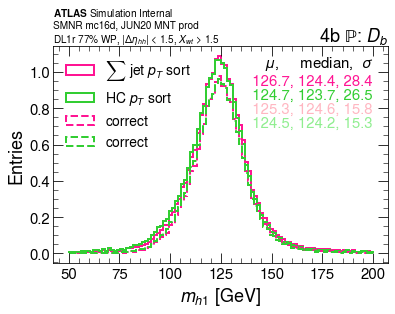

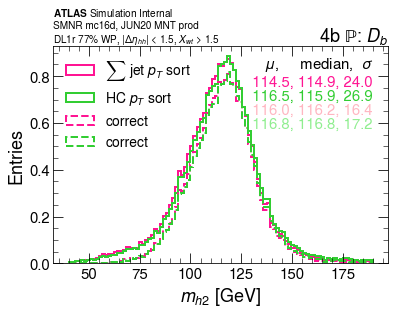

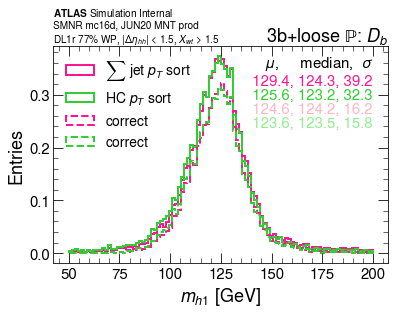

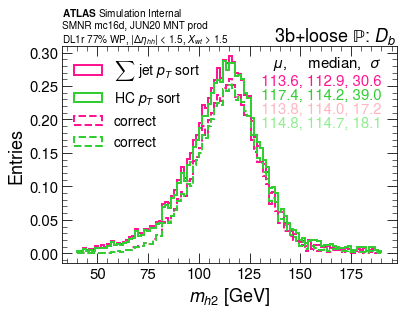

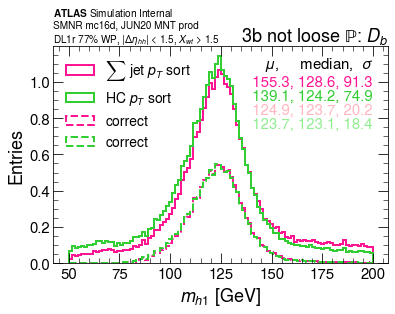

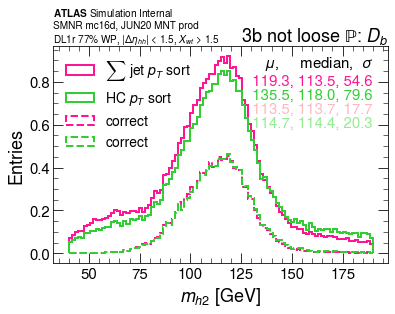

In [104]:
df, title = pag_Db, '$\mathrm{\mathbb{P}}$: $D_b$'


lc = ['k','deeppink','limegreen','lightpink','lightgreen']

for ntag, mi,titleTag,tag in zip([4,3,3], [(df.ntag_pag==4),(df.minQ==2),(df.minQ==1)],
                                 ['','+loose',' not loose'],['','loose','notLoose']):
    m = (df.ntag_pag==ntag) & mi & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    
    print(f'{ntag}b{titleTag}',np.sum(df.loc[m&(df.m_h1==df.m_lead),'mc_sf'])/np.sum(df.loc[m,'mc_sf']))
    
    '''
    Leading HC
    '''
    plt.figure()

    plt.hist(df.loc[m,'m_h1'],100,(50,200),label='$\sum$ jet $p_T$ sort',
             color='deeppink',histtype='step',lw=2,weights=df.loc[m,'mc_sf'])
    plt.hist(df.loc[m,'m_lead'], 100,(50,200),label='HC $p_T$ sort',
             color='limegreen',histtype='step',lw=2,weights=df.loc[m,'mc_sf'])
    
    plt.hist(df.loc[m & (df.chosenPair==df.correctPair),'m_h1'],
             100,(50,200),label='correct',ls='--',
             color='deeppink',histtype='step',lw=2,
             weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'])
    plt.hist(df.loc[m& (df.chosenPair==df.correctPair),'m_lead'],
             100,(50,200),label='correct',ls='--',
             color='limegreen',histtype='step',lw=2,
             weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'])
    
    m1_text = ['$\mu$,     median,  $\sigma$']
    for v,w in zip([*df.loc[m,['m_h1','m_lead']].values.T,
                    *df.loc[m & (df.chosenPair==df.correctPair),['m_h1','m_lead']].values.T],
                   [*df.loc[m,['mc_sf','mc_sf']].values.T,
                    *df.loc[m & (df.chosenPair==df.correctPair),['mc_sf','mc_sf']].values.T]):
        
        weighted_stats = DescrStatsW(v, weights=w, ddof=0)
        
        mu = weighted_stats.mean
        median = weighted.median(v,w)
        std = weighted_stats.std
       
        m1_text.append(f'{mu : .1f},{median: .1f},{std: .1f}')
    
    
    plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.legend(loc='upper left')
    
    ax = plt.gca()
    plt.title(f'{ntag}b{titleTag} {title}',transform=ax.transAxes,loc='right')
    plt.text(0,1,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
    rainbow_text(200, 0.9*plt.ylim()[1], m1_text, lc, ax=ax,ha='right', yoffset=1)
    
    '''
    Subleading HC
    '''
    plt.figure()
        
    plt.hist(df.loc[m,'m_h2'],100,(40,190),label='$\sum$ jet $p_T$ sort',
             color='deeppink',histtype='step',lw=2,weights=df.loc[m,'mc_sf'])
    plt.hist(df.loc[m,'m_subl'],100,(40,190),label='HC $p_T$ sort',
             color='limegreen',histtype='step',lw=2,weights=df.loc[m,'mc_sf'])
    
    
    plt.hist(df.loc[m & (df.chosenPair==df.correctPair),'m_h2'],
             100,(40,190),label='correct',ls='--',
             color='deeppink',histtype='step',lw=2,
             weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'])
    plt.hist(df.loc[m& (df.chosenPair==df.correctPair),'m_subl'],
             100,(40,190),label='correct',ls='--',
             color='limegreen',histtype='step',lw=2,
             weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'])
    
    
    m2_text = ['$\mu$,     median,  $\sigma$']
    
    for v,w in zip([*df.loc[m,['m_h2','m_subl']].values.T,
                    *df.loc[m & (df.chosenPair==df.correctPair),['m_h2','m_subl']].values.T],
                   [*df.loc[m,['mc_sf','mc_sf']].values.T,
                    *df.loc[m & (df.chosenPair==df.correctPair),['mc_sf','mc_sf']].values.T]):
        
        weighted_stats = DescrStatsW(v, weights=w, ddof=0)
        
        mu = weighted_stats.mean
        median = weighted.median(v,w)
        std = weighted_stats.std
       
        m2_text.append(f'{mu : .1f},{median: .1f},{std: .1f}')
    
    plt.xlabel('$m_{h2}$ [GeV]',fontsize=18) 
    plt.ylabel('Entries',fontsize=18)
    plt.legend(loc='upper left')
    
    ax = plt.gca()
    plt.title(f'{ntag}b{titleTag} {title}',transform=ax.transAxes,loc='right')
    plt.text(0,1,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
    rainbow_text(190, 0.9*plt.ylim()[1], m2_text, lc, ax=ax,ha='right', yoffset=1)
    
    #break
    
# plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/preLN_lr_0p003/mp_{ntag}b{tag}_Xwt_hcSort.pdf',
#             bbox_inches='tight')
plt.show()

**Next:** $m_{hh}$ in the SR for the old and new configurations

In [108]:
from analysis import getXhh

In [120]:
pag_Db['Xhh_new'] = getXhh(pag_Db.m_h1, pag_Db.m_h2, 125,116)
pag_Db['Xhh_ptSort_new'] = getXhh(pag_Db.m_lead, pag_Db.m_subl, 124,116.5)

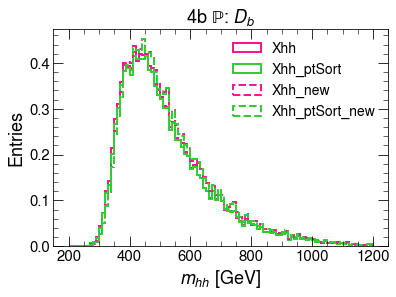

In [121]:
ns = []

for v,c,ls in zip(['Xhh','Xhh_ptSort','Xhh_new','Xhh_ptSort_new'],
                      ['deeppink','limegreen']*2,['-']*2+['--']*2): 

    m = (df.ntag_pag==4) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    n,e,_ = plt.hist(df.loc[m&(df[v]<1.6),'m_hh'],100,[200,1200],
             color=c,
             label=v,histtype='step',
             lw=2,ls=ls,weights=df.loc[m&(df[v]<1.6),'mc_sf'])
    
    ns.append(n)
    
plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
plt.ylabel('Entries',fontsize=18)
plt.title(f'4b {title}')
plt.legend()
plt.show()

**Q:** What's the gain in signal?

/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


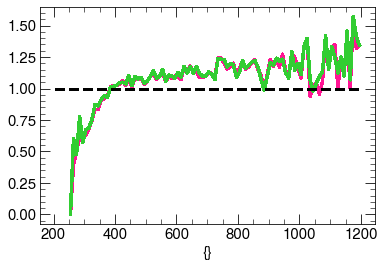

In [122]:
xx = 0.5 * (e[1:] + e[:-1])

plt.plot(xx, ns[2] / ns[0], color='deeppink',label='sum jpt sort')
plt.plot(xx, ns[3] / ns[1], color='limegreen',label='HC pt sort')

plt.xlabel('{}')
plt.plot(xx,np.ones_like(xx),'k--')

plt.show()

In [74]:
np.min(df.loc[m,'m_h1']-df.loc[m,'m_lead']),np.max(df.loc[m,'m_h1']-df.loc[m,'m_lead'])

(-788.0623286659013, 2552.4321098808596)

In [75]:
np.mean(df.loc[m,'m_h1']-df.loc[m,'m_lead'])

15.827352425533572

In [83]:
150/100

1.5

In [105]:
# df, title = pag_Db, '$\mathrm{\mathbb{P}}$: $D_b$'

# for ntag, mi,titleTag,tag in zip([4,3,3], [(df.ntag_pag==4),(df.minQ==2),(df.minQ==1)],
#                                  ['','+loose',' not loose'],['','loose','notLoose']):
#     m = (df.ntag_pag==ntag) & mi & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    
#     print(f'{ntag}b{titleTag}',np.sum(df.loc[m&((df.m_h1-df.m_lead)<1.5),'mc_sf'])/np.sum(df.loc[m,'mc_sf']))
    
#     plt.figure()

#     v = df.loc[m,'m_h1']-df.loc[m,'m_lead']
#     w = df.loc[m,'m_h2']-df.loc[m,'m_subl']
    
#     plt.hist(v[v!=0],100,(-50,50),label='lead',
#              color='deeppink',histtype='step',lw=2,
#              weights=df.loc[m,'mc_sf'][v!=0])
# #     plt.hist(w[w!=0],100,(-50,50),label='subl',
# #              color='limegreen',histtype='step',lw=2,weights=df.loc[m,'mc_sf'][w!=0])
    
    
#     plt.xlabel('$m_{h1}$: (jpt sort - HC sort)',fontsize=18)
#     plt.ylabel('Entries',fontsize=18)
#     plt.legend(loc='upper left')
    
#     ax = plt.gca()
#     plt.title(f'{ntag}b{titleTag} {title}',transform=ax.transAxes,loc='right')
#     plt.text(0,1,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
    
        
# # plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/preLN_lr_0p003/mp_{ntag}b{tag}_Xwt_hcSort.pdf',
# #             bbox_inches='tight')
# plt.show()

In [ ]:
# df, title = pag_Db, '$\mathrm{\mathbb{P}}$: $D_b$'

# for ntag, mi,titleTag,tag in zip([4,3,3], [(df.ntag_pag==4),(df.minQ==2),(df.minQ==1)],
#                                  ['','+loose',' not loose'],['','loose','notLoose']):
#     m = (df.ntag_pag==ntag) & mi & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

    
#     print(f'{ntag}b{titleTag}',np.sum(df.loc[m&(df.m_h1==df.m_lead),'mc_sf'])/np.sum(df.loc[m,'mc_sf']))
    
#     '''
#     Leading HC
#     '''
#     plt.figure()

#     plt.hist(df.loc[m,'m_h1'],df.loc[m,'m_lead'],100,(50,200),label='$\sum$ jet $p_T$ sort',
#              color='dRdPu',histtype='step',lw=2,weights=df.loc[m,'mc_sf'])
#     plt.hist( 100,(50,200),label='HC $p_T$ sort',
#              color='limegreen',histtype='step',lw=2,weights=df.loc[m,'mc_sf'])
    
#     plt.xlabel('$m_{h1}$ [GeV]',fontsize=18)
#     plt.ylabel('Entries',fontsize=18)
#     plt.legend(loc='upper left')
    
#     ax = plt.gca()
#     plt.title(f'{ntag}b{titleTag} {title}',transform=ax.transAxes,loc='right')
#     plt.text(0,1,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
    
    

#     '''
#     Subleading HC
#     '''
# #     plt.figure()
        
# #     plt.hist(df.loc[m,'m_h2'],100,(40,190),label='$\sum$ jet $p_T$ sort',
# #              color='deeppink',histtype='step',lw=2,weights=df.loc[m,'mc_sf'])
# #     plt.hist(df.loc[m,'m_subl'],100,(40,190),label='HC $p_T$ sort',
# #              color='limegreen',histtype='step',lw=2,weights=df.loc[m,'mc_sf'])
    
    
# #     plt.hist(df.loc[m & (df.chosenPair==df.correctPair),'m_h2'],
# #              100,(40,190),label='correct',ls='--',
# #              color='deeppink',histtype='step',lw=2,
# #              weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'])
# #     plt.hist(df.loc[m& (df.chosenPair==df.correctPair),'m_subl'],
# #              100,(40,190),label='correct',ls='--',
# #              color='limegreen',histtype='step',lw=2,
# #              weights=df.loc[m & (df.chosenPair==df.correctPair),'mc_sf'])
    
# #     plt.xlabel('$m_{h2}$ [GeV]',fontsize=18) 
# #     plt.ylabel('Entries',fontsize=18)
# #     plt.legend(loc='upper left')
    
# #     ax = plt.gca()
# #     plt.title(f'{ntag}b{titleTag} {title}',transform=ax.transAxes,loc='right')
# #     plt.text(0,1,fmp,transform=ax.transAxes,ha='left',va='bottom',fontsize=10)
    
    
# # plt.savefig(f'figures/{physicsSample}_{mc}-{prodTag}-{nSelectedJets}jets/preLN_lr_0p003/mp_{ntag}b{tag}_Xwt_hcSort.pdf',
# #             bbox_inches='tight')
# plt.show()

**Alright - so the *outstanding Q* is whether with $\mathrm{\mathbb{P}}$ can take better advantage of the 3b category.**

**Thoughts...** I believe if we can use the purple training, it's probably best to break this down into **three** different $b$-tagging categories.

If we can't use the purple training, I should retrain pink w/ the btag sort, and then we can probably use the 3b category *alone*.

In [174]:
df = pag_Db
m = (df.ntag_pag>=4) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

print(np.sum((df.loc[m,'lead_pt'] > 400) * df.loc[m,'mc_sf']) / np.sum(df.loc[m,'mc_sf']))

m = m & (df.kinematic_region == 0)
print(np.sum((df.loc[m,'lead_pt'] > 400) * df.loc[m,'mc_sf']) / np.sum(df.loc[m,'mc_sf']))

0.011845195624930388
0.013465234161470212


In [176]:
df = pag_Db
Db_min_pag = np.min(df[[f'Db_h{i}_j{j}' for i,j in product([1,2],[1,2])]].values,axis=1)
m = (df.ntag_pag==3) & (Db_min_pag == 2) & (df.abs_deta_hh < 1.5) & (df.X_wt > 1.5)

print(np.sum((df.loc[m,'lead_pt'] > 400) * df.loc[m,'mc_sf']) / np.sum(df.loc[m,'mc_sf']))

m = m & (df.kinematic_region == 0)
print(np.sum((df.loc[m,'lead_pt'] > 400) * df.loc[m,'mc_sf']) / np.sum(df.loc[m,'mc_sf']))

0.01622031556162347
0.014631200868708474


Also - to compare w/ the JZ nb, look @ the impact b/w ntag and ntag_pag for *signal*

In [37]:
m1s = [dR1.abs_deta_hh < 1.5, (dR1.abs_deta_hh < 1.5) & (dR1.X_wt > 1.5)]
m1s = m1s + [m1s[-1] & (dR1.kinematic_region==i) for i in range(3)]

m2s = [pag_Db.abs_deta_hh < 1.5, (pag_Db.abs_deta_hh < 1.5) & (pag_Db.X_wt > 1.5)]
m2s = m1s + [m1s[-1] & (pag_Db.kinematic_region==i) for i in range(3)]

titles = ['$|\Delta \eta_{hh}| < 1.5$','$X_{wt}$ > 1.5','SR','VR','CR']

$|\Delta \eta_{hh}| < 1.5$ 0.9766931280507493
$X_{wt}$ > 1.5 0.9803218665713175
SR 0.9974775976246979


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


VR 0.9953668679159962
CR 0.9866822858109613


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


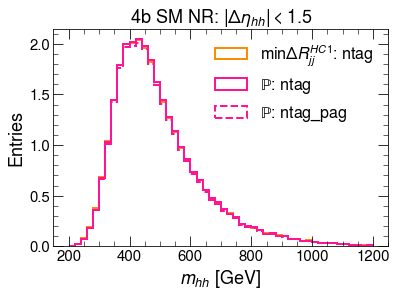

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


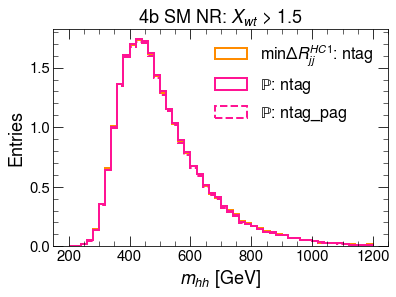

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


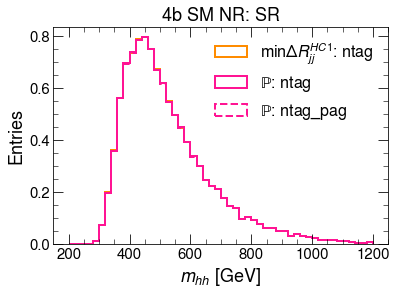

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


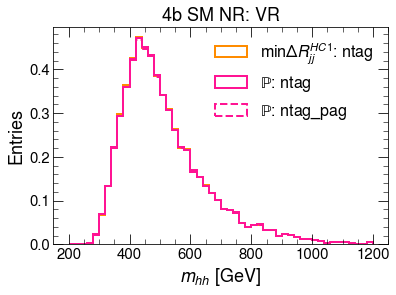

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


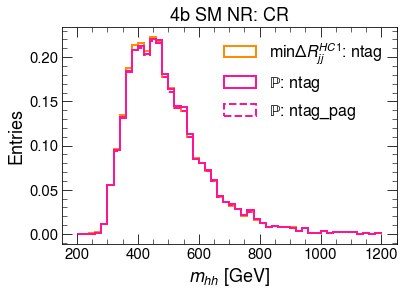

In [38]:
nb = 50
r = (200,1200)

for m1,m2,title in zip(m1s, m2s, titles):
 
    plt.figure()
    plt.hist(dR1.loc[(dR1.ntag>=4) & m1,'m_hh'],nb,r,histtype='step',lw=2,ls='-',color='darkorange',
             weights=dR1.loc[(dR1.ntag>=4) & m1,'mc_sf'],label='$\min \Delta R_{jj}^{HC 1}$: ntag')

    plt.hist(pag_Db.loc[(pag_Db.ntag>=4) & m2,'m_hh'],nb,r,histtype='step',lw=2,ls='-',color='deeppink',
             weights=pag_Db.loc[(pag_Db.ntag>=4) & m2,'mc_sf'],label='$\mathrm{\mathbb{P}}$: ntag')

    plt.hist(pag_Db.loc[(pag_Db.ntag_pag==4) & m2,'m_hh'],nb,r,histtype='step',lw=2,ls='--',color='deeppink',
             weights=pag_Db.loc[(pag_Db.ntag_pag==4) & m2,'mc_sf'],label='$\mathrm{\mathbb{P}}$: ntag_pag')

#     plt.hist(pag_btag.loc[pag_btag.ntag>=4,'m_hh'],nb,r,histtype='step',lw=2,ls='-',color='turquoise',
#              weights=pag_btag.loc[pag_btag.ntag>=4,'mc_sf'],label='$\mathrm{\mathbb{P}}$: ntag')

#     plt.hist(pag_btag.loc[pag_btag.ntag_pag==4,'m_hh'],nb,r,histtype='step',lw=2,ls='--',color='turquoise',
#              weights=pag_btag.loc[pag_btag.ntag_pag==4,'mc_sf'],label='$\mathrm{\mathbb{P}}$: ntag_pag')

    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.title(f'4b SM NR: {title}')
    plt.legend(fontsize=16)
    
    
    num = np.sum(pag_Db.loc[(pag_Db.ntag_pag>=4) & m2,'mc_sf'])
    den = np.sum(pag_Db.loc[(pag_Db.ntag>=4) & m2,'mc_sf'])

    print(title, num / den)
    
plt.show()

This is kind of amazing that I don't see *any* change in the categories - even in the VR... **did something go wrong here?**

$|\Delta \eta_{hh}| < 1.5$ 0.9766931280507493
$X_{wt}$ > 1.5 0.9803218665713175
SR 0.9974775976246979
VR 0.9953668679159962
CR 0.9866822858109613


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


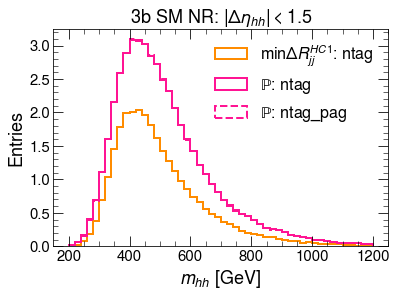

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


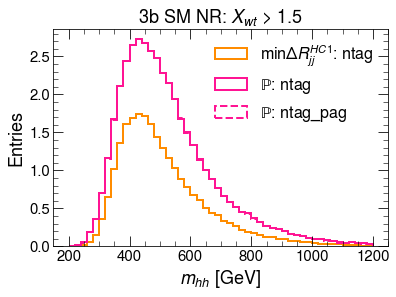

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


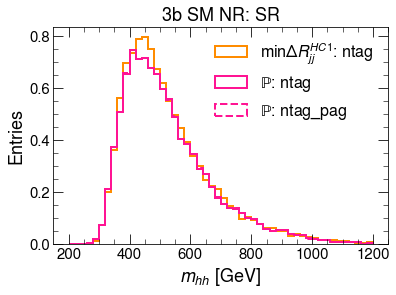

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


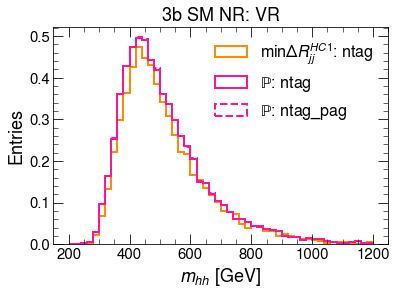

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


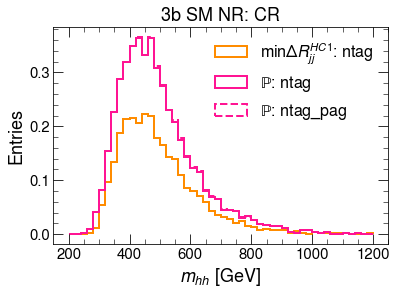

In [94]:
nb = 50
r = (200,1200)

for m1,m2,title in zip(m1s, m2s, titles):
 
    plt.figure()
    plt.hist(dR1.loc[(dR1.ntag>=4) & m1,'m_hh'],nb,r,histtype='step',lw=2,ls='-',color='darkorange',
             weights=dR1.loc[(dR1.ntag>=4) & m1,'mc_sf'],label='$\min \Delta R_{jj}^{HC 1}$: ntag')

    plt.hist(pag_Db.loc[(pag_Db.ntag==3) & m2,'m_hh'],nb,r,histtype='step',lw=2,ls='-',color='deeppink',
             weights=pag_Db.loc[(pag_Db.ntag==3) & m2,'mc_sf'],label='$\mathrm{\mathbb{P}}$: ntag')

    plt.hist(pag_Db.loc[(pag_Db.ntag_pag==3) & m2,'m_hh'],nb,r,histtype='step',lw=2,ls='--',color='deeppink',
             weights=pag_Db.loc[(pag_Db.ntag_pag==3) & m2,'mc_sf'],label='$\mathrm{\mathbb{P}}$: ntag_pag')

#     plt.hist(pag_btag.loc[pag_btag.ntag==3,'m_hh'],nb,r,histtype='step',lw=2,ls='-',color='turquoise',
#              weights=pag_btag.loc[pag_btag.ntag==3,'mc_sf'],label='$\mathrm{\mathbb{P}}$: ntag')

#     plt.hist(pag_btag.loc[pag_btag.ntag_pag==3,'m_hh'],nb,r,histtype='step',lw=2,ls='--',color='turquoise',
#              weights=pag_btag.loc[pag_btag.ntag_pag==3,'mc_sf'],label='$\mathrm{\mathbb{P}}$: ntag_pag')

    plt.xlabel('$m_{hh}$ [GeV]',fontsize=18)
    plt.ylabel('Entries',fontsize=18)
    plt.title(f'3b SM NR: {title}')
    plt.legend(fontsize=16)
    
    
    num = np.sum(pag_Db.loc[(pag_Db.ntag_pag>=4) & m2,'mc_sf'])
    den = np.sum(pag_Db.loc[(pag_Db.ntag>=4) & m2,'mc_sf'])

    print(title, num / den)
    
plt.show()

Wow - these are very very similar histograms for 3b as well lol